In [1]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new/")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow_probability.substrates import jax as tfp

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# TriplePandelSPE/JAX stuff
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data
from lib.smaller_network_eqx import get_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track
#from likelihood_mpe_w_noise import get_neg_c_triple_gamma_llh
#from likelihood_spe_w_noise_logsumexp import get_neg_c_triple_gamma_llh
from likelihood_conv_mpe_w_noise_logsumexp import get_neg_c_triple_gamma_llh
#from likelihood_conv_mpe_w_noise import get_neg_c_triple_gamma_llh
from palettable.cubehelix import Cubehelix
cx =Cubehelix.make(start=0.3, rotation=-0.5, n=16, reverse=True, gamma=1.0,
                           max_light=1.0,max_sat=0.5, min_sat=1.4).get_mpl_colormap()

import time

In [162]:
# Event Index.
event_index = 4

# Get network and eval logic.
dtype = jnp.float64
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/smaller_network_eqx/tpn_smallest_default_tree_start_epoch_192', dtype=jnp.float64)
#eval_network_v = get_network_eval_v_fn(bpath="/home/storage/hans/photondata/train_in_jax/cache_z_and_dist_penalty/w_z_and_dist_penalty_tpn_smallest_default_tree_start_epoch_190.eqx", dtype=jnp.float64)
eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, dtype=jnp.float64)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'

#sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
#                              os.path.join(bp, 'pulses_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
#                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

print("n_doms", len(event_data))

# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

muon energy: 6.2 TeV
n_doms 45
original seed vertex: [  -65.71173861  1800.82339061 -1057.15159503]
shifted seed vertex: [ 407.88112043  162.47186024 -234.15666758]


In [163]:
# Clip charge and combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())
print(fitting_event_data.shape)

# Setup likelihood
neg_llh = get_neg_c_triple_gamma_llh(eval_network_doms_and_track)
print(neg_llh(track_src, centered_track_pos, centered_track_time, fitting_event_data))

(45, 5)
578.920120309521


In [164]:
import time

In [202]:
scale = 30.0
scale_rad = 30.0

solver = optx.BFGS(rtol=1e-8, atol=1e-4, use_inverse=True)

@jax.jit
def neg_llh_5D(x, args):
        # project back if outside of [0, pi] x [0, 2*pi]
        zenith = x[0] / scale_rad
        azimuth = x[1] / scale_rad
        zenith = jnp.fmod(zenith, 2.0*jnp.pi)
        zenith = jnp.where(zenith < 0, zenith+2.0*jnp.pi, zenith)
        cond = zenith > jnp.pi
        zenith = jnp.where(cond, -1.0*zenith+2.0*jnp.pi, zenith)
        azimuth = jnp.where(cond, azimuth-jnp.pi, azimuth)

        azimuth = jnp.fmod(azimuth, 2.0*jnp.pi)
        azimuth = jnp.where(azimuth < 0, azimuth+2.0*jnp.pi, azimuth)

        projected_dir = jnp.array([zenith, azimuth])
        return neg_llh(projected_dir, x[2:]*scale, centered_track_time, fitting_event_data)

@jax.jit
def run_5D(x0):
    best_x = optx.minimise(neg_llh_5D, solver, x0, throw=False).value
    best_logl = neg_llh_5D(best_x, None)
    return best_logl, best_x
    
start = time.time()
x0 = jnp.concatenate([track_src*scale_rad, centered_track_pos/scale])
best_logl, best_x = run_5D(x0)
print(best_logl, best_x)
end = time.time()
print("took: ", end-start, " s")

570.8886371522577 [60.59287508 55.20185674 13.45971092  5.34419814 -7.87721698]
took:  3.2467918395996094  s


In [203]:
negllh_time_v = jax.jit(jax.vmap(neg_llh, (None, None, 0, None), 0))

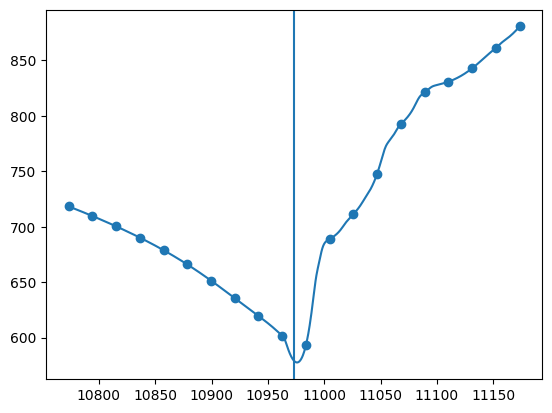

In [204]:
dt = 200
tv = jnp.linspace(centered_track_time - dt, centered_track_time + dt, 1000)
tv2 = jnp.linspace(centered_track_time - dt, centered_track_time + dt, 20)
tllh = negllh_time_v(track_src, centered_track_pos, tv, fitting_event_data)
tllh2 = negllh_time_v(track_src, centered_track_pos, tv2, fitting_event_data)
plt.plot(tv, tllh)
plt.axvline(centered_track_time)
plt.scatter(tv2, tllh2)

In [205]:
# %timeit negllh_time_v(track_src, centered_track_pos, tv, fitting_event_data)

In [206]:
ix = jnp.argmin(tllh)
print(centered_track_time - tv[ix])

-2.6026026026029285


In [207]:
dt = 300
tv = jnp.linspace(centered_track_time - dt, centered_track_time + dt, 1000)
tv2 = jnp.linspace(centered_track_time - dt, centered_track_time + dt, 20)
#tdir = jnp.deg2rad(jnp.array([117.0, 223.0]))
tdir = jnp.deg2rad(jnp.array([105.0, 110.0]))
tllh = negllh_time_v(tdir, centered_track_pos, tv, fitting_event_data)
tllh2 = negllh_time_v(tdir, centered_track_pos, tv2, fitting_event_data)
print(tllh)
ix = jnp.argmin(tllh2)
#print(ix, centered_track_time - tv2[ix])

[721.98749154 721.89113286 721.79575541 721.70137383 721.60800289
 721.51565757 721.42435298 721.33410443 721.24492738 721.15683749
 721.06985057 720.98398261 720.89924976 720.81566837 720.73325495
 720.65202617 720.57199889 720.49319014 720.41561711 720.33929718
 720.26424787 720.1904869  720.11803213 720.0469016  719.97711349
 719.90868617 719.84163813 719.77598803 719.71175467 719.64895701
 719.58761411 719.52774518 719.46936957 719.41250672 719.35717619
 719.30339763 719.25119081 719.20057555 719.15157174 719.10419935
 719.05847837 719.01442883 718.97207078 718.93142425 718.89250927
 718.85534583 718.81995383 718.78635312 718.75456345 718.72460442
 718.69649548 718.67025591 718.64590477 718.62346087 718.60294277
 718.58436868 718.56775651 718.55312376 718.54048752 718.52986443
 718.52127059 718.5147216  718.51023245 718.5078175  718.50749041
 718.50926414 718.51315086 718.51916193 718.52730782 718.5375981
 718.55004136 718.5646452  718.58141615 718.60035964 718.62147998
 718.644780

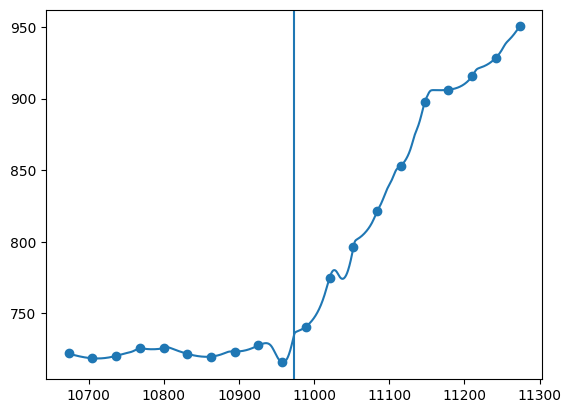

In [208]:
plt.plot(tv, tllh)
plt.scatter(tv2, tllh2)
plt.axvline(centered_track_time)

In [209]:
x0 = centered_track_pos / scale

@jax.jit
def neg_llh_3D(x, args):
    track_dir = args[:3]
    track_time = args[3]
    return neg_llh(track_dir, x*scale, track_time, fitting_event_data)

def run_3D(track_dir, track_time):
    args = jnp.concatenate([track_dir, jnp.expand_dims(track_time, axis=0)])
    values = optx.minimise(neg_llh_3D, solver, x0, args=args, throw=False).value
    return neg_llh_3D(values, args), values * scale

In [210]:
centered_track_pos

Array([ 407.88112043,  162.47186024, -234.15666758], dtype=float64)

In [211]:
# Number of scan points on 1D
n_eval = 50 # making it a 20x20 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.2 # rad
dazi = 0.2 # rad

zenith = jnp.linspace(track_src[0]-dzen, track_src[0]+dazi, n_eval)
azimuth = jnp.linspace(track_src[1]-dzen, track_src[1]+dazi, n_eval)
X, Y = jnp.meshgrid(zenith, azimuth)
init_dirs = jnp.column_stack([X.flatten(), Y.flatten()])

In [212]:
dt = 500.
tv = jnp.linspace(centered_track_time - dt, centered_track_time + 100, 100)

def get_track_time(track_dir):
    llh = negllh_time_v(track_dir, centered_track_pos, tv, fitting_event_data)
    ix = jnp.argmin(llh, axis=0)
    return ix

print(tv[get_track_time(track_src)], centered_track_time)
print(tv[get_track_time(tdir)], centered_track_time)

10976.28472714553 10973.254424115226
10958.10290896371 10973.254424115226


In [213]:
get_track_time_v = jax.jit(jax.vmap(get_track_time, 0, 0))

In [214]:
init_dirs.shape

(2500, 2)

In [215]:
start = time.time()
n_splits = 10
_init_dirs = init_dirs.reshape((n_splits, init_dirs.shape[0]//n_splits , init_dirs.shape[1]))
indices = []
for x in _init_dirs:
    indices.append(get_track_time_v(x))

end = time.time()
print(end-start)

2.761517286300659


In [216]:
indices = jnp.concatenate(indices)
print(indices.shape)

(2500,)


In [217]:
init_times = jnp.take_along_axis(tv, indices, axis=0)

In [218]:
print(init_times)

[10667.19381805 10679.31503018 10691.4362423  ... 10903.55745442
 10903.55745442 10897.49684836]


In [219]:
#start = time.time()
#print(get_track_time_v(init_dirs))
#end = time.time()
#print(end-start)

In [220]:
#print(init_times)

In [221]:
run_3D_v = jax.jit(jax.vmap(run_3D, (0, 0), (0, 0)))

In [222]:
tic = time.time()
logls, sol_pos = run_3D_v(init_dirs, init_times)
toc = time.time()

In [223]:
print(toc-tic)

33.34117674827576


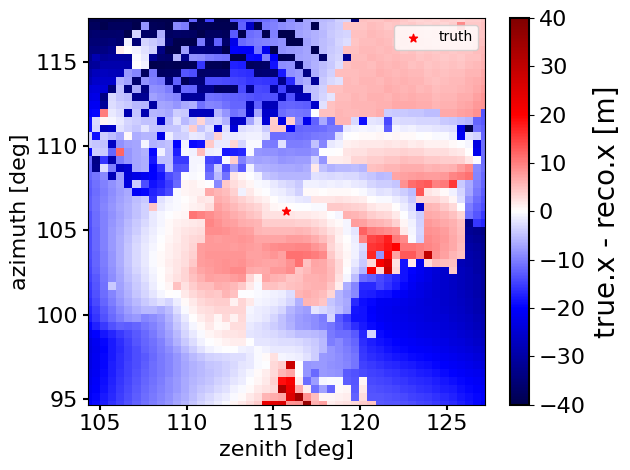

In [224]:
logls = logls.reshape(X.shape)
sol_x = sol_pos[:, 0].reshape(X.shape)
sol_y = sol_pos[:, 1].reshape(X.shape)
sol_z = sol_pos[:, 2].reshape(X.shape)

fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), centered_track_pos[0]-sol_x, vmin=-40, vmax=+40, shading='auto', cmap=mpl.colormaps['seismic'])
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("true.x - reco.x [m]", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

plt.legend()
plt.tight_layout()

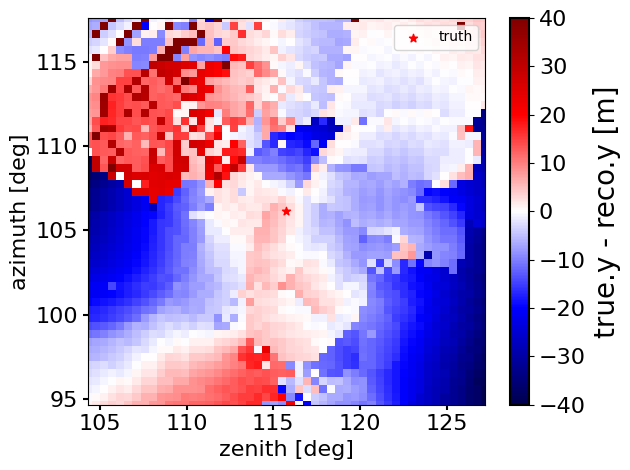

In [225]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), centered_track_pos[1]-sol_y, vmin=-40, vmax=+40, shading='auto', cmap=mpl.colormaps['seismic'])
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("true.y - reco.y [m]", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

plt.legend()
plt.tight_layout()

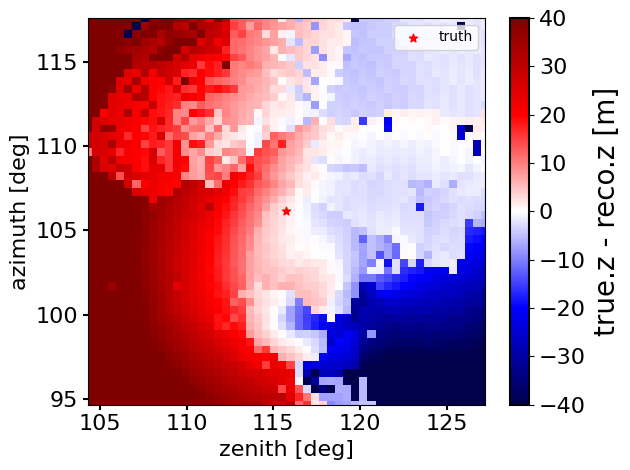

In [226]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), centered_track_pos[2]-sol_z, vmin=-40, vmax=+40, shading='auto', cmap=mpl.colormaps['seismic'])
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("true.z - reco.z [m]", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

plt.legend()
plt.tight_layout()

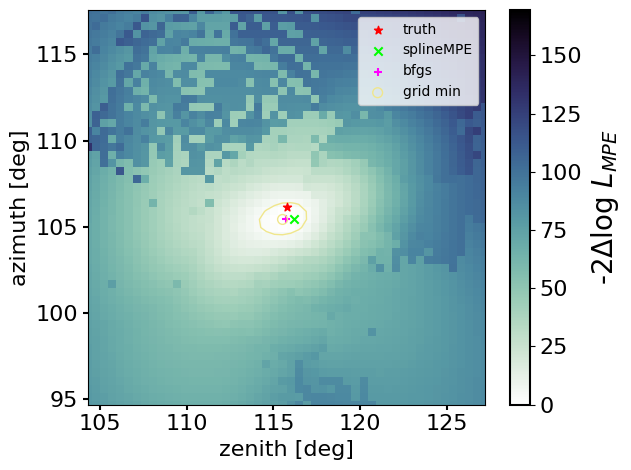

In [227]:
fig, ax = plt.subplots()
min_logl = np.amin(logls)
delta_logl = logls - np.amin(logls)
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), delta_logl, vmin=0, vmax=np.min([500, 1.2*np.amax(delta_logl)]), shading='auto', cmap=cx)
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("-2$\\Delta$log $L_{MPE}$", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

smpe_zenith = meta['spline_mpe_zenith']
smpe_azimuth = meta['spline_mpe_azimuth']
ax.scatter(np.rad2deg([smpe_zenith]), np.rad2deg([smpe_azimuth]), marker="x", color='lime', label='splineMPE')

zenith = best_x[0] / scale_rad
azimuth = best_x[1] / scale_rad
ax.scatter(np.rad2deg(zenith), np.rad2deg(azimuth), marker='+', color='magenta', label='bfgs')

contours = [4.61]
ix1, ix2 = np.where(delta_logl==0)
ax.scatter(np.rad2deg([X[ix1, ix2]]), np.rad2deg([Y[ix1, ix2]]), s=50, marker='o', facecolors='none', edgecolors='khaki', zorder=100., label='grid min')
ct = plt.contour(np.rad2deg(X), np.rad2deg(Y), delta_logl, levels=contours, linestyles=['solid'], colors=['khaki'], linewidths=1.0)

plt.legend()
plt.tight_layout()

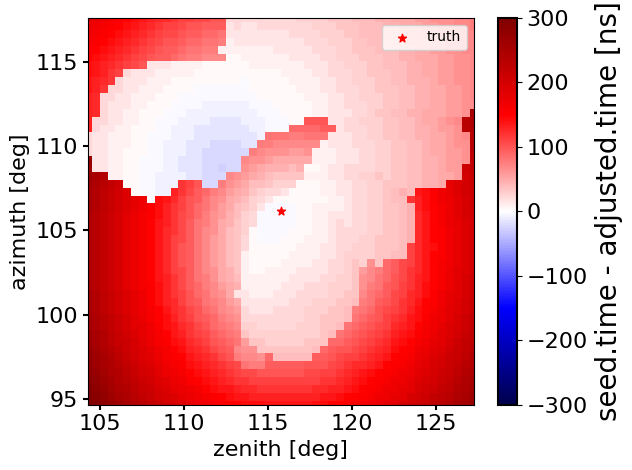

In [228]:
fig, ax = plt.subplots()
pc = ax.pcolormesh(np.rad2deg(X), np.rad2deg(Y), centered_track_time - init_times.reshape(X.shape), vmin=-300, vmax=+300, shading='auto', cmap=mpl.colormaps['seismic'])
cbar = fig.colorbar(pc)
cbar.ax.tick_params(labelsize=16)
cbar.ax.get_yaxis().labelpad = 5
cbar.set_label("seed.time - adjusted.time [ns]", fontsize=20)
cbar.outline.set_linewidth(1.5)

ax.set_xlabel("zenith [deg]", fontsize=16)
ax.set_ylabel("azimuth [deg]", fontsize=16)
ax.set_xlim(np.rad2deg([track_src[0]-dzen, track_src[0]+dzen]))
ax.set_ylim(np.rad2deg([track_src[1]-dazi, track_src[1]+dazi]))
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)

ax.scatter(np.rad2deg(track_src[0]), np.rad2deg(track_src[1]), marker="*", color='red', label="truth", zorder=200)

plt.legend()
plt.tight_layout()

In [229]:
init_times

Array([10667.19381805, 10679.31503018, 10691.4362423 , ...,
       10903.55745442, 10903.55745442, 10897.49684836], dtype=float64)

In [230]:
x = jnp.array([[1,2,3], [4,5,6]])

Array([[2, 3],
       [5, 6]], dtype=int64)